# Polynomial Fit Method

This notebook is to explore the polynomial fit-based definition of the mean profile from the Castro group. First, let's compare to the box used in the deep_dive notebook. Then if things go well we can explore the globe

In [18]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate

In [19]:
import os
os.chdir('/home/amf2288/argo-intern/funcs')
import filt_funcs as ff
import density_funcs as df

In [20]:
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize']  = 18
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

## Load Section

In [27]:
ds_p = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_high_res_1.nc')

In [28]:
section = ds_p.where((ds_p.LATITUDE < -25) & (ds_p.LATITUDE > -35),drop=True).where((ds_p.LONGITUDE < -138) & (ds_p.LONGITUDE > -140),drop=True).sortby('LATITUDE')

In [29]:
section = section.sortby('N_PROF')

#only keep profiles with at least n data points
ct_counts = section['CT'].count(dim='PRES_INTERPOLATED')
profiles_to_keep = ct_counts >= 500
section_p = section.sel(N_PROF=profiles_to_keep).sortby('LATITUDE')

In [30]:
section_p = section_p.rename({'PRES_INTERPOLATED':'PRESSURE','N_PROF':'PROFILE','LATITUDE':'LAT','LONGITUDE':'LON'})

In [31]:
section_p['SIG1'] = (('PROFILE','PRESSURE'), gsw.density.sigma1(section_p.SA, section_p.CT).values)

In [32]:
nprof = section_p.dims["PROFILE"]
section_p = section_p.assign_coords(NUM=("PROFILE", np.arange(nprof)))

/home/amf2288/miniconda3/envs/Argo_Feb_25/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


## Polynomial fit method to calculate C_m, C_e

In [21]:
def moving_average(arr, window, center=True, mode="reflect"):
    """
    Moving average that returns the same number of points as the input.

    Parameters
    ----------
    arr : array-like (1D)
        Input profile.
    window : int
        Size of the moving window (>=1).
    center : bool, default True
        If True, use a centered window; if False, use a trailing window.
    mode : str, default 'reflect'
        Padding mode passed to np.pad for edge handling. Common options:
        'reflect', 'edge', 'nearest', 'wrap', 'constant'.

    Returns
    -------
    np.ndarray
        Smoothed array with the same length as arr.
    """
    a = np.asarray(arr, dtype=float)
    if a.ndim != 1:
        raise ValueError("moving_average expects a 1D array (profile)")
    if window <= 1:
        return a.copy()

    kernel = np.ones(int(window), dtype=float) / float(window)

    if center:
        left = window // 2
        right = window - 1 - left
    else:
        left = window - 1
        right = 0

    padded = np.pad(a, (left, right), mode=mode)
    out = np.convolve(padded, kernel, mode="valid")
    # out length will be len(a)
    return out

In [22]:
def smooth_profile_1d(sig0, ct, sa, spice, window=5, center=True, mode='reflect', degree=4):
    """
    Smooth a single profile along PRESSURE using polynomial fit and moving average.

    Parameters
    ----------
    sig0, ct, sa, spice : 1D arrays (PRESSURE)
        Inputs for one profile.
    window : int
        Moving average window size.
    center : bool
        Use centered window if True; trailing if False.
    mode : str
        Padding mode for moving_average.
    degree : int
        Polynomial fit degree (default 4).

    Returns
    -------
    ct_out, sa_out, spice_out : 1D arrays (PRESSURE)
        Smoothed values, NaN where input was invalid.
    """
    sig0 = np.asarray(sig0)
    ct   = np.asarray(ct)
    sa   = np.asarray(sa)
    spice= np.asarray(spice)
    n = sig0.size
    ct_out    = np.full(n, np.nan)
    sa_out    = np.full(n, np.nan)
    spice_out = np.full(n, np.nan)
    
    valid_mask = np.isfinite(ct + sig0)
    jj = np.flatnonzero(valid_mask)
    if jj.size < max(window, degree + 1):
        return ct_out, sa_out, spice_out
    
    sig0_valid  = sig0[jj]
    ct_valid    = ct[jj]
    sa_valid    = sa[jj]
    spice_valid = spice[jj]
    
    # Fit polynomials
    p_ct = np.polyfit(sig0_valid, ct_valid, degree)
    p_sa = np.polyfit(sig0_valid, sa_valid, degree)
    p_sp = np.polyfit(sig0_valid, spice_valid, degree)
    pp_ct = np.poly1d(p_ct)
    pp_sa = np.poly1d(p_sa)
    pp_sp = np.poly1d(p_sp)
    
    # Sort by density and smooth
    sort_idx    = np.argsort(sig0_valid)
    sig0_sorted = sig0_valid[sort_idx]
    sig0_smooth = moving_average(sig0_sorted, window, center=center, mode=mode)
    
    # Check if smoothed density is still monotonic
    if len(sig0_smooth) != len(sig0_sorted):
        # Length mismatch after moving average
        return ct_out, sa_out, spice_out
    
    # Ensure strict monotonicity by adding tiny increments where needed
    diffs = np.diff(sig0_smooth)
    if np.any(diffs <= 0):
        # Make strictly increasing by adding small epsilon
        for i in range(len(diffs)):
            if diffs[i] <= 0:
                sig0_smooth[i+1] = sig0_smooth[i] + 1e-10
    
    # Evaluate at smoothed density and interpolate back to original valid points
    ct_smooth    = pp_ct(sig0_smooth)
    sa_smooth    = pp_sa(sig0_smooth)
    spice_smooth = pp_sp(sig0_smooth)
    
    try:
        f_ct    = interpolate.PchipInterpolator(sig0_smooth, ct_smooth, extrapolate=False)
        f_sa    = interpolate.PchipInterpolator(sig0_smooth, sa_smooth, extrapolate=False)
        f_spice = interpolate.PchipInterpolator(sig0_smooth, spice_smooth, extrapolate=False)
        ct_out[jj]    = f_ct(sig0_valid)
        sa_out[jj]    = f_sa(sig0_valid)
        spice_out[jj] = f_spice(sig0_valid)
    except (ValueError, RuntimeError) as e:
        # Leave NaNs if interpolation fails
        pass
    
    return ct_out, sa_out, spice_out

In [23]:
def smooth_profiles_apply_ufunc(section_p, sig_var='SIG0', window=5, center=True, mode='reflect', degree=4, use_dask=True, chunk_size=32, progress=True):
    """
    Parallel smoothing across PROFILE using xarray.apply_ufunc.

    Returns a new Dataset with CT_m, SA_m, SPICE_m.
    Shows a dask ProgressBar when dask is available; otherwise falls back to a tqdm loop.
    """
    import xarray as xr
    ds = section_p
    # Ensure expected dims
    if not {'PROFILE','PRESSURE'}.issubset(ds.dims):
        raise ValueError("section_p must have dims ('PROFILE','PRESSURE')")
    
    # Try dask path
    use_dask_path = False
    if use_dask:
        try:
            import dask  # noqa: F401
            from dask.diagnostics import ProgressBar
            use_dask_path = True
        except Exception:
            use_dask_path = False
    
    if use_dask_path:
        ds_chunked = ds.chunk({'PROFILE': chunk_size})
        def _func(s, c, a, p):
            return smooth_profile_1d(s, c, a, p, window=window, center=center, mode=mode, degree=degree)
        ct_da, sa_da, spice_da = xr.apply_ufunc(
            _func,
            ds_chunked[sig_var], ds_chunked['CT'], ds_chunked['SA'], ds_chunked['SPICE'],
            input_core_dims=[['PRESSURE'], ['PRESSURE'], ['PRESSURE'], ['PRESSURE']],
            output_core_dims=[['PRESSURE'], ['PRESSURE'], ['PRESSURE']],
            vectorize=True,
            dask='parallelized',
            output_dtypes=[float, float, float]
        )
        # Ensure dimension order
        ct_da    = ct_da.transpose('PROFILE','PRESSURE')
        sa_da    = sa_da.transpose('PROFILE','PRESSURE')
        spice_da = spice_da.transpose('PROFILE','PRESSURE')
        if progress:
            with ProgressBar():
                ct_da    = ct_da.compute()
                sa_da    = sa_da.compute()
                spice_da = spice_da.compute()
        ds_out = ds.copy()
        ds_out['CT_m']    = ct_da
        ds_out['SA_m']    = sa_da
        ds_out['SPICE_m'] = spice_da
        
        ds_out['CT_e']    = ds_out['CT'] - ds_out['CT_m']
        ds_out['SA_e']    = ds_out['SA'] - ds_out['SA_m']
        ds_out['SPICE_e'] = ds_out['SPICE'] - ds_out['SPICE_m']
        return ds_out
    else:
        # Fallback: tqdm over profiles without dask
        from tqdm.auto import tqdm
        nprof = ds.dims['PROFILE']
        npres = ds.dims['PRESSURE']
        CT_m    = np.full((nprof, npres), np.nan)
        SA_m    = np.full((nprof, npres), np.nan)
        SPICE_m = np.full((nprof, npres), np.nan)
        for i in tqdm(range(nprof), desc='Smoothing profiles', disable=not progress):
            prof = ds.isel(PROFILE=i)
            ct_out, sa_out, spice_out = smooth_profile_1d(
                prof[sig_var].values, prof['CT'].values, prof['SA'].values, prof['SPICE'].values,
                window=window, center=center, mode=mode, degree=degree
            )
            CT_m[i, :]    = ct_out
            SA_m[i, :]    = sa_out
            SPICE_m[i, :] = spice_out
        ds_out = ds.copy()
        ds_out['CT_m']    = (('PROFILE','PRESSURE'), CT_m)
        ds_out['SA_m']    = (('PROFILE','PRESSURE'), SA_m)
        ds_out['SPICE_m'] = (('PROFILE','PRESSURE'), SPICE_m)

        ds_out['CT_e'] = (('PROFILE','PRESSURE'), ds_out['CT'] - ds_out['CT_m'])
        ds_out['SA_e'] = (('PROFILE','PRESSURE'), ds_out['SA'] - ds_out['SA_m'])
        ds_out['SPICE_e'] = (('PROFILE','PRESSURE'), ds_out['SPICE'] - ds_out['SPICE_m'])
        return ds_out

In [24]:
def smooth_profile_1d_local_window(sig0, ct, sa, spice, pressure, pressure_window=500, density_window=5, center=True, mode='reflect', degree=4, min_points=None):
    """
    Smooth a single profile using LOCAL polynomial fits with a moving pressure window.
    
    For each pressure level, fit a polynomial using only data within a pressure window,
    then evaluate at that specific level. This allows different depth ranges to be fit
    independently, avoiding the issue where upper ocean variability constrains deep ocean fits.

    Parameters
    ----------
    sig0, ct, sa, spice : 1D arrays (PRESSURE)
        Inputs for one profile.
    pressure : 1D array (PRESSURE)
        Pressure levels corresponding to the data.
    pressure_window : float
        Size of the pressure window in dbar (e.g., 500 means ±250 dbar around each level).
    density_window : int
        Moving average window size for density smoothing within each local window.
    center : bool
        Use centered window for density smoothing if True; trailing if False.
    mode : str
        Padding mode for moving_average.
    degree : int
        Polynomial fit degree (default 4).
    min_points : int, optional
        Minimum number of points required in window for fitting.
        If None, defaults to max(density_window, degree + 1).

    Returns
    -------
    ct_out, sa_out, spice_out : 1D arrays (PRESSURE)
        Smoothed values, NaN where input was invalid or insufficient data.
    """
    sig0 = np.asarray(sig0)
    ct   = np.asarray(ct)
    sa   = np.asarray(sa)
    spice = np.asarray(spice)
    pressure = np.asarray(pressure)
    n = sig0.size
    
    if min_points is None:
        min_points = max(density_window, degree + 1)
    
    ct_out    = np.full(n, np.nan)
    sa_out    = np.full(n, np.nan)
    spice_out = np.full(n, np.nan)
    
    # First pass: identify which pressure levels have sufficient valid data in their windows
    valid_global = np.isfinite(ct) & np.isfinite(sig0)
    
    if np.sum(valid_global) < min_points:
        return ct_out, sa_out, spice_out
    
    # Use global fit with local pressure weighting instead of per-level fitting
    # This dramatically reduces computation while still respecting pressure windows
    sig0_valid = sig0[valid_global]
    ct_valid   = ct[valid_global]
    sa_valid   = sa[valid_global]
    spice_valid = spice[valid_global]
    pressure_valid = pressure[valid_global]
    
    # Fit polynomials once on all valid data
    try:
        p_ct = np.polyfit(sig0_valid, ct_valid, degree)
        p_sa = np.polyfit(sig0_valid, sa_valid, degree)
        p_sp = np.polyfit(sig0_valid, spice_valid, degree)
        pp_ct = np.poly1d(p_ct)
        pp_sa = np.poly1d(p_sa)
        pp_sp = np.poly1d(p_sp)
    except (np.linalg.LinAlgError, ValueError):
        return ct_out, sa_out, spice_out
    
    # Sort by density and smooth once
    sort_idx = np.argsort(sig0_valid)
    sig0_sorted = sig0_valid[sort_idx]
    
    # Apply moving average to density
    if len(sig0_sorted) >= density_window:
        sig0_smooth = moving_average(sig0_sorted, density_window, center=center, mode=mode)
        
        # Ensure monotonicity
        diffs = np.diff(sig0_smooth)
        if np.any(diffs <= 0):
            for k in range(len(diffs)):
                if diffs[k] <= 0:
                    sig0_smooth[k+1] = sig0_smooth[k] + 1e-10
    else:
        sig0_smooth = sig0_sorted
    
    # Evaluate polynomials at smoothed densities
    ct_smooth    = pp_ct(sig0_smooth)
    sa_smooth    = pp_sa(sig0_smooth)
    spice_smooth = pp_sp(sig0_smooth)
    
    # Create single interpolators
    try:
        f_ct    = interpolate.PchipInterpolator(sig0_smooth, ct_smooth, extrapolate=False)
        f_sa    = interpolate.PchipInterpolator(sig0_smooth, sa_smooth, extrapolate=False)
        f_spice = interpolate.PchipInterpolator(sig0_smooth, spice_smooth, extrapolate=False)
    except (ValueError, RuntimeError):
        return ct_out, sa_out, spice_out
    
    # Evaluate at all valid pressure points, respecting pressure window constraints
    pressure_half_window = pressure_window / 2
    
    for i in range(n):
        if not valid_global[i]:
            continue
        
        p_center = pressure[i]
        p_min = p_center - pressure_half_window
        p_max = p_center + pressure_half_window
        
        # Find points within the pressure window
        window_mask = (pressure_valid >= p_min) & (pressure_valid <= p_max)
        
        if np.sum(window_mask) < min_points:
            continue  # Not enough points in this window
        
        sig0_center = sig0[i]
        
        try:
            ct_out[i]    = f_ct(sig0_center)
            sa_out[i]    = f_sa(sig0_center)
            spice_out[i] = f_spice(sig0_center)
        except (ValueError, RuntimeError):
            continue
    
    return ct_out, sa_out, spice_out

In [ ]:
def smooth_profile_1d_local_window(sig0, ct, sa, spice, pressure, pressure_window=500, density_window=5, center=True, mode='reflect', degree=4, min_points=None):
    """
    Smooth a single profile using LOCAL polynomial fits with a moving pressure window.
    
    For each pressure level, fit a polynomial using only data within a pressure window,
    then evaluate at that specific level. This allows different depth ranges to be fit
    independently, avoiding the issue where upper ocean variability constrains deep ocean fits.

    Parameters
    ----------
    sig0, ct, sa, spice : 1D arrays (PRESSURE)
        Inputs for one profile.
    pressure : 1D array (PRESSURE)
        Pressure levels corresponding to the data.
    pressure_window : float
        Size of the pressure window in dbar (e.g., 500 means ±250 dbar around each level).
    density_window : int
        Moving average window size for density smoothing within each local window.
    center : bool
        Use centered window for density smoothing if True; trailing if False.
    mode : str
        Padding mode for moving_average.
    degree : int
        Polynomial fit degree (default 4).
    min_points : int, optional
        Minimum number of points required in window for fitting.
        If None, defaults to max(density_window, degree + 1).

    Returns
    -------
    ct_out, sa_out, spice_out : 1D arrays (PRESSURE)
        Smoothed values, NaN where input was invalid or insufficient data.
    """
    sig0 = np.asarray(sig0)
    ct   = np.asarray(ct)
    sa   = np.asarray(sa)
    spice = np.asarray(spice)
    pressure = np.asarray(pressure)
    n = sig0.size
    
    if min_points is None:
        min_points = max(density_window, degree + 1)
    
    ct_out    = np.full(n, np.nan)
    sa_out    = np.full(n, np.nan)
    spice_out = np.full(n, np.nan)
    
    # Precompute valid mask globally
    valid_global = np.isfinite(ct) & np.isfinite(sig0)
    pressure_half_window = pressure_window / 2
    
    # Cache for storing window data to avoid recomputation
    # We'll process overlapping windows more efficiently
    for i in range(n):
        if not valid_global[i]:
            continue
            
        p_center = pressure[i]
        p_min = p_center - pressure_half_window
        p_max = p_center + pressure_half_window
        
        # Find points within the pressure window
        window_mask = (pressure >= p_min) & (pressure <= p_max) & valid_global
        jj = np.flatnonzero(window_mask)
        
        if jj.size < min_points:
            continue  # Leave as NaN
        
        # Extract windowed data
        sig0_win  = sig0[jj]
        ct_win    = ct[jj]
        sa_win    = sa[jj]
        spice_win = spice[jj]
        
        # Sort by density
        sort_idx = np.argsort(sig0_win)
        sig0_sorted = sig0_win[sort_idx]
        ct_sorted = ct_win[sort_idx]
        sa_sorted = sa_win[sort_idx]
        spice_sorted = spice_win[sort_idx]
        
        # Apply moving average to density if we have enough points
        if len(sig0_sorted) >= density_window:
            sig0_smooth = moving_average(sig0_sorted, density_window, center=center, mode=mode)
            
            # Ensure monotonicity
            diffs = np.diff(sig0_smooth)
            if np.any(diffs <= 0):
                for k in range(len(diffs)):
                    if diffs[k] <= 0:
                        sig0_smooth[k+1] = sig0_smooth[k] + 1e-10
        else:
            sig0_smooth = sig0_sorted
        
        # Fit polynomials within this window using sorted data
        try:
            p_ct = np.polyfit(sig0_sorted, ct_sorted, degree)
            p_sa = np.polyfit(sig0_sorted, sa_sorted, degree)
            p_sp = np.polyfit(sig0_sorted, spice_sorted, degree)
            pp_ct = np.poly1d(p_ct)
            pp_sa = np.poly1d(p_sa)
            pp_sp = np.poly1d(p_sp)
        except (np.linalg.LinAlgError, ValueError):
            continue  # Skip if fit fails
        
        # Evaluate polynomials at smoothed densities
        ct_smooth    = pp_ct(sig0_smooth)
        sa_smooth    = pp_sa(sig0_smooth)
        spice_smooth = pp_sp(sig0_smooth)
        
        # Interpolate back to the center point's original density
        sig0_center = sig0[i]
        
        try:
            f_ct    = interpolate.PchipInterpolator(sig0_smooth, ct_smooth, extrapolate=False)
            f_sa    = interpolate.PchipInterpolator(sig0_smooth, sa_smooth, extrapolate=False)
            f_spice = interpolate.PchipInterpolator(sig0_smooth, spice_smooth, extrapolate=False)
            
            ct_out[i]    = f_ct(sig0_center)
            sa_out[i]    = f_sa(sig0_center)
            spice_out[i] = f_spice(sig0_center)
        except (ValueError, RuntimeError):
            # Leave as NaN if interpolation fails
            continue
    
    return ct_out, sa_out, spice_out

In [26]:
def smooth_profiles_apply_ufunc_local_window(section_p, sig_var='SIG0', pressure_window=500, density_window=5, 
                                              center=True, mode='reflect', degree=4, use_dask=True, 
                                              chunk_size=32, progress=True):
    """
    Parallel smoothing across PROFILE using local pressure window approach with xarray.apply_ufunc.

    Parameters
    ----------
    section_p : xarray.Dataset
        Dataset with dims ('PROFILE','PRESSURE') containing CT, SA, SPICE, and sig_var.
    sig_var : str
        Name of the density variable to use for fitting (default 'SIG0').
    pressure_window : float
        Size of pressure window in dbar for local fits (e.g., 500).
    density_window : int
        Moving average window size for density smoothing within each local window.
    center : bool
        Use centered window for density smoothing if True.
    mode : str
        Padding mode for moving_average.
    degree : int
        Polynomial fit degree (default 4).
    use_dask : bool
        Try to use dask for parallel computation if available.
    chunk_size : int
        Chunk size for dask along PROFILE dimension.
    progress : bool
        Show progress bar.

    Returns
    -------
    xarray.Dataset
        New Dataset with CT_m, SA_m, SPICE_m, CT_e, SA_e, SPICE_e added.
    """
    import xarray as xr
    ds = section_p
    
    # Ensure expected dims
    if not {'PROFILE','PRESSURE'}.issubset(ds.dims):
        raise ValueError("section_p must have dims ('PROFILE','PRESSURE')")
    
    # Get pressure coordinate values
    pressure_values = ds['PRESSURE'].values
    
    # Try dask path
    use_dask_path = False
    if use_dask:
        try:
            import dask  # noqa: F401
            from dask.diagnostics import ProgressBar
            use_dask_path = True
        except Exception:
            use_dask_path = False
    
    if use_dask_path:
        ds_chunked = ds.chunk({'PROFILE': chunk_size})
        
        def _func(s, c, a, p):
            return smooth_profile_1d_local_window(
                s, c, a, p, pressure_values, 
                pressure_window=pressure_window, 
                density_window=density_window, 
                center=center, 
                mode=mode, 
                degree=degree
            )
        
        ct_da, sa_da, spice_da = xr.apply_ufunc(
            _func,
            ds_chunked[sig_var], ds_chunked['CT'], ds_chunked['SA'], ds_chunked['SPICE'],
            input_core_dims=[['PRESSURE'], ['PRESSURE'], ['PRESSURE'], ['PRESSURE']],
            output_core_dims=[['PRESSURE'], ['PRESSURE'], ['PRESSURE']],
            vectorize=True,
            dask='parallelized',
            output_dtypes=[float, float, float]
        )
        
        # Ensure dimension order
        ct_da    = ct_da.transpose('PROFILE','PRESSURE')
        sa_da    = sa_da.transpose('PROFILE','PRESSURE')
        spice_da = spice_da.transpose('PROFILE','PRESSURE')
        
        if progress:
            with ProgressBar():
                ct_da    = ct_da.compute()
                sa_da    = sa_da.compute()
                spice_da = spice_da.compute()
        
        ds_out = ds.copy()
        ds_out['CT_m']    = ct_da
        ds_out['SA_m']    = sa_da
        ds_out['SPICE_m'] = spice_da
        
        ds_out['CT_e']    = ds_out['CT'] - ds_out['CT_m']
        ds_out['SA_e']    = ds_out['SA'] - ds_out['SA_m']
        ds_out['SPICE_e'] = ds_out['SPICE'] - ds_out['SPICE_m']
        return ds_out
    else:
        # Fallback: tqdm over profiles without dask
        from tqdm.auto import tqdm
        nprof = ds.dims['PROFILE']
        npres = ds.dims['PRESSURE']
        CT_m    = np.full((nprof, npres), np.nan)
        SA_m    = np.full((nprof, npres), np.nan)
        SPICE_m = np.full((nprof, npres), np.nan)
        
        for i in tqdm(range(nprof), desc='Smoothing profiles (local window)', disable=not progress):
            prof = ds.isel(PROFILE=i)
            ct_out, sa_out, spice_out = smooth_profile_1d_local_window(
                prof[sig_var].values, prof['CT'].values, prof['SA'].values, prof['SPICE'].values,
                pressure_values,
                pressure_window=pressure_window, density_window=density_window, 
                center=center, mode=mode, degree=degree
            )
            CT_m[i, :]    = ct_out
            SA_m[i, :]    = sa_out
            SPICE_m[i, :] = spice_out
        
        ds_out = ds.copy()
        ds_out['CT_m']    = (('PROFILE','PRESSURE'), CT_m)
        ds_out['SA_m']    = (('PROFILE','PRESSURE'), SA_m)
        ds_out['SPICE_m'] = (('PROFILE','PRESSURE'), SPICE_m)

        ds_out['CT_e'] = (('PROFILE','PRESSURE'), ds_out['CT'] - ds_out['CT_m'])
        ds_out['SA_e'] = (('PROFILE','PRESSURE'), ds_out['SA'] - ds_out['SA_m'])
        ds_out['SPICE_e'] = (('PROFILE','PRESSURE'), ds_out['SPICE'] - ds_out['SPICE_m'])
        return ds_out

In [33]:
# Test with different pressure window sizes
section_local_500 = smooth_profiles_apply_ufunc_local_window(section_p, 'SIG1', pressure_window=500, density_window=10, center=True, mode='reflect', degree=4, use_dask=True, chunk_size=32, progress=True)

[########################################] | 100% Completed | 112.19 s
[########################################] | 100% Completed | 113.14 s
[########################################] | 100% Completed | 113.41 s


In [34]:
# Try a larger window
section_local_750 = smooth_profiles_apply_ufunc_local_window(section_p, 'SIG1', pressure_window=750, density_window=10, center=True, mode='reflect', degree=4, use_dask=True, chunk_size=32, progress=True)

[########################################] | 100% Completed | 112.87 s
[########################################] | 100% Completed | 112.86 s
[########################################] | 100% Completed | 112.56 s


In [35]:
# And a smaller window
section_local_300 = smooth_profiles_apply_ufunc_local_window(section_p, 'SIG1', pressure_window=300, density_window=10, center=True, mode='reflect', degree=4, use_dask=True, chunk_size=32, progress=True)

[########################################] | 100% Completed | 113.80 s
[########################################] | 100% Completed | 113.52 s
[########################################] | 100% Completed | 113.24 s


Local polynomial fit with moving pressure window


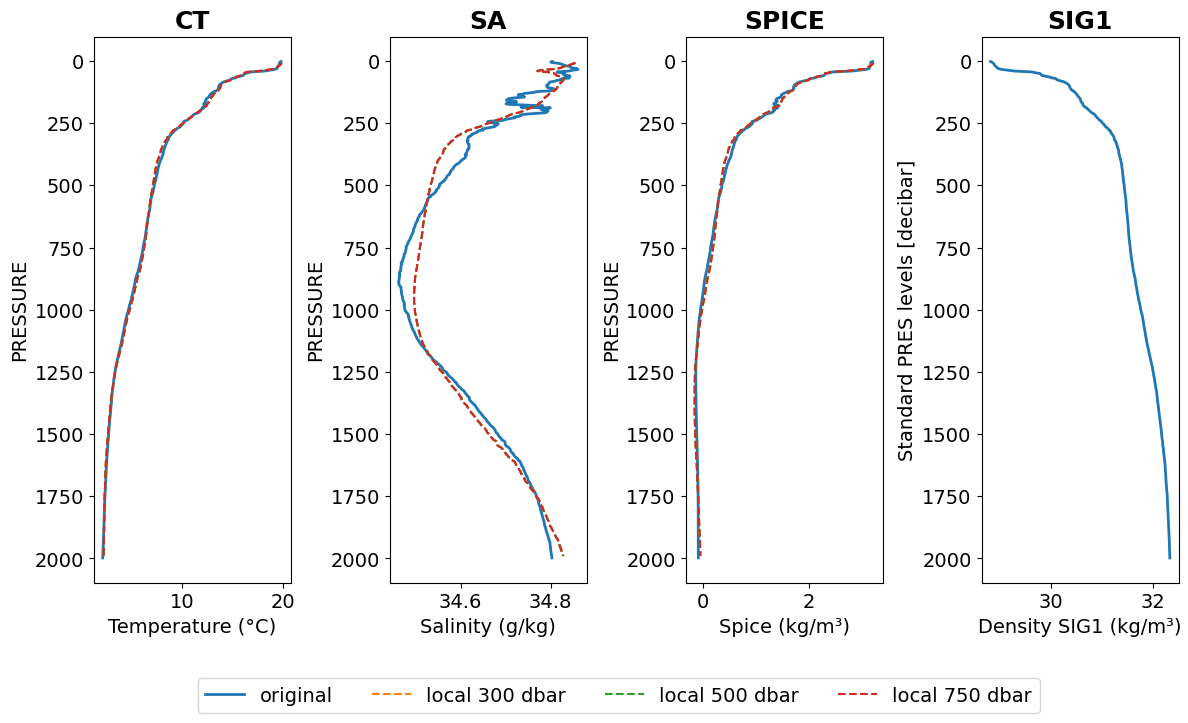

In [36]:
# Compare local window approach with different window sizes
plt.figure(figsize=(14,7))
prof = 1

plt.subplot(141)
section_p.isel(PROFILE=prof).CT.plot(y='PRESSURE', label='original', linewidth=2)
section_local_300.isel(PROFILE=prof).CT_m.plot(y='PRESSURE', label='local 300 dbar', linestyle='--')
section_local_500.isel(PROFILE=prof).CT_m.plot(y='PRESSURE', label='local 500 dbar', linestyle='--')
section_local_750.isel(PROFILE=prof).CT_m.plot(y='PRESSURE', label='local 750 dbar', linestyle='--')
plt.xlabel('Temperature (°C)')
plt.gca().invert_yaxis()
plt.title('CT')

plt.subplot(142)
section_p.isel(PROFILE=prof).SA.plot(y='PRESSURE', linewidth=2)
section_local_300.isel(PROFILE=prof).SA_m.plot(y='PRESSURE', linestyle='--')
section_local_500.isel(PROFILE=prof).SA_m.plot(y='PRESSURE', linestyle='--')
section_local_750.isel(PROFILE=prof).SA_m.plot(y='PRESSURE', linestyle='--')
plt.xlabel('Salinity (g/kg)')
plt.gca().invert_yaxis()
plt.title('SA')

plt.subplot(143)
section_p.isel(PROFILE=prof).SPICE.plot(y='PRESSURE', linewidth=2)
section_local_300.isel(PROFILE=prof).SPICE_m.plot(y='PRESSURE', linestyle='--')
section_local_500.isel(PROFILE=prof).SPICE_m.plot(y='PRESSURE', linestyle='--')
section_local_750.isel(PROFILE=prof).SPICE_m.plot(y='PRESSURE', linestyle='--')
plt.xlabel('Spice (kg/m³)')
plt.gca().invert_yaxis()
plt.title('SPICE')

plt.subplot(144)
section_p.isel(PROFILE=prof).SIG1.plot(y='PRESSURE', linewidth=2)
plt.xlabel('Density SIG1 (kg/m³)')
plt.gca().invert_yaxis()
plt.title('SIG1')

plt.subplots_adjust(wspace=0.5, bottom=0.1)
plt.figlegend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=4)
print('Local polynomial fit with moving pressure window')

Comparison: Global polynomial fit vs Local window approach


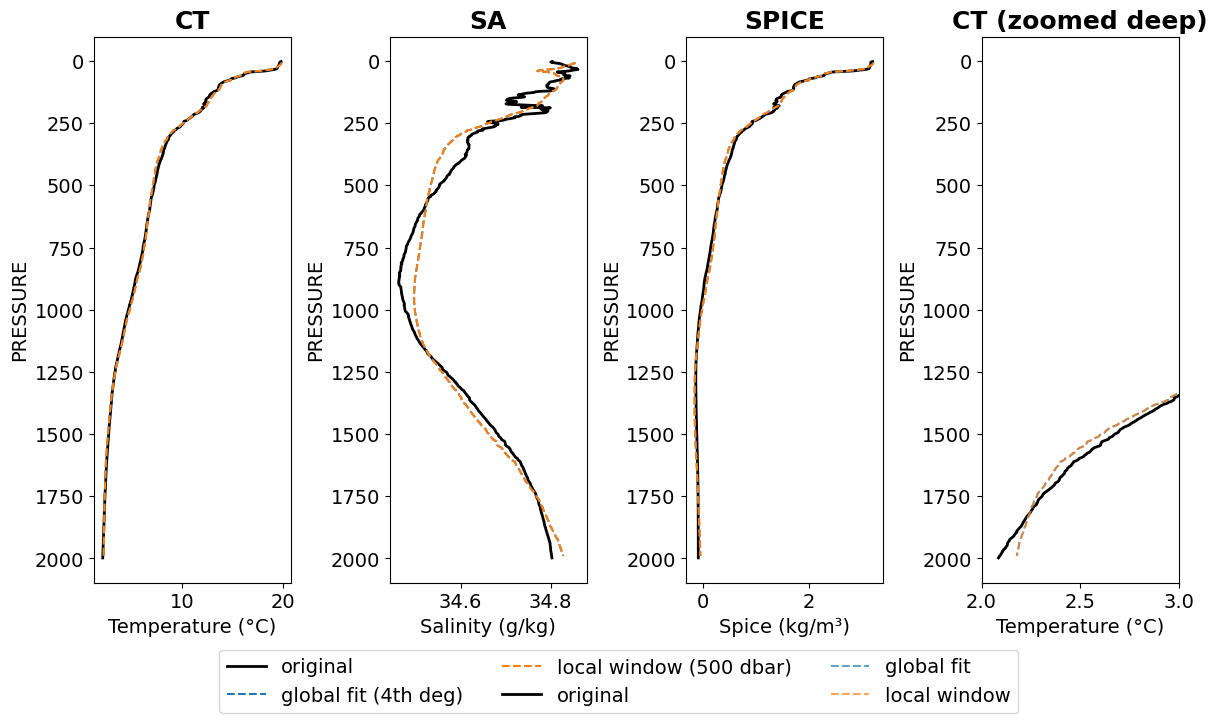

In [42]:
# Compare local window (500 dbar) with global fit (from section_4)
plt.figure(figsize=(14,7))
prof = 1

plt.subplot(141)
section_p.isel(PROFILE=prof).CT.plot(y='PRESSURE', label='original', linewidth=2, color='black')
section_4.isel(PROFILE=prof).CT_m.plot(y='PRESSURE', label='global fit (4th deg)', linestyle='--', color='tab:blue')
section_local_500.isel(PROFILE=prof).CT_m.plot(y='PRESSURE', label='local window (500 dbar)', linestyle='--', color='tab:orange')
plt.xlabel('Temperature (°C)')
plt.gca().invert_yaxis()
plt.title('CT')

plt.subplot(142)
section_p.isel(PROFILE=prof).SA.plot(y='PRESSURE', linewidth=2, color='black')
section_4.isel(PROFILE=prof).SA_m.plot(y='PRESSURE', linestyle='--', color='tab:blue')
section_local_500.isel(PROFILE=prof).SA_m.plot(y='PRESSURE', linestyle='--', color='tab:orange')
plt.xlabel('Salinity (g/kg)')
plt.gca().invert_yaxis()
plt.title('SA')

plt.subplot(143)
section_p.isel(PROFILE=prof).SPICE.plot(y='PRESSURE', linewidth=2, color='black')
section_4.isel(PROFILE=prof).SPICE_m.plot(y='PRESSURE', linestyle='--', color='tab:blue')
section_local_500.isel(PROFILE=prof).SPICE_m.plot(y='PRESSURE', linestyle='--', color='tab:orange')
plt.xlabel('Spice (kg/m³)')
plt.gca().invert_yaxis()
plt.title('SPICE')

plt.subplot(144)
section_p.isel(PROFILE=prof).CT.plot(y='PRESSURE', label='original', linewidth=2, color='black')
section_4.isel(PROFILE=prof).CT_m.plot(y='PRESSURE', label='global fit', linestyle='--', color='tab:blue', alpha=0.7)
section_local_500.isel(PROFILE=prof).CT_m.plot(y='PRESSURE', label='local window', linestyle='--', color='tab:orange', alpha=0.7)
plt.xlim(2, 3)  # Focus on deep ocean
plt.xlabel('Temperature (°C)')
plt.gca().invert_yaxis()
plt.title('CT (zoomed deep)')

plt.subplots_adjust(wspace=0.5, bottom=0.1)
plt.figlegend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3)
print('Comparison: Global polynomial fit vs Local window approach')

In [38]:
section_3 = smooth_profiles_apply_ufunc(section_p, 'SIG1', window=10, center=True, mode='reflect', degree=3, use_dask=True, chunk_size=32, progress=True)
section_4 = smooth_profiles_apply_ufunc(section_p, 'SIG1', window=10, center=True, mode='reflect', degree=4, use_dask=True, chunk_size=32, progress=True)
section_5 = smooth_profiles_apply_ufunc(section_p, 'SIG1', window=10, center=True, mode='reflect', degree=5, use_dask=True, chunk_size=32, progress=True)
#section_6 = smooth_profiles_apply_ufunc(section_p, 'SIG1', window=10, center=True, mode='reflect', degree=6, use_dask=True, chunk_size=32, progress=True)

[########################################] | 100% Completed | 4.56 sms
[########################################] | 100% Completed | 4.53 sms
[########################################] | 100% Completed | 4.51 sms
[########################################] | 100% Completed | 4.65 sms
[########################################] | 100% Completed | 4.65 sms
[########################################] | 100% Completed | 4.62 sms
[########################################] | 100% Completed | 4.70 sms
[########################################] | 100% Completed | 4.74 sms
[########################################] | 100% Completed | 4.78 sms


In [39]:
section_3_slice = smooth_profiles_apply_ufunc(section_p.sel(PRESSURE=slice(375,1850)), 'SIG1', window=10, center=True, mode='reflect', degree=3, use_dask=True, chunk_size=32, progress=True)
section_4_slice = smooth_profiles_apply_ufunc(section_p.sel(PRESSURE=slice(375,1850)), 'SIG1', window=10, center=True, mode='reflect', degree=4, use_dask=True, chunk_size=32, progress=True)
section_5_slice = smooth_profiles_apply_ufunc(section_p.sel(PRESSURE=slice(375,1850)), 'SIG1', window=10, center=True, mode='reflect', degree=5, use_dask=True, chunk_size=32, progress=True)
#section_6_slice = smooth_profiles_apply_ufunc(section_p.sel(PRESSURE=slice(375,1850)), 'SIG1', window=10, center=True, mode='reflect', degree=6, use_dask=True, chunk_size=32, progress=True)

[########################################] | 100% Completed | 4.39 sms
[########################################] | 100% Completed | 4.24 sms
[########################################] | 100% Completed | 4.28 sms
[########################################] | 100% Completed | 4.34 sms
[########################################] | 100% Completed | 4.34 sms
[########################################] | 100% Completed | 4.37 sms
[#####                                   ] | 12% Completed | 3.34 s ms

/tmp/ipykernel_159708/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_159708/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_159708/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)


[########################################] | 100% Completed | 4.45 s
[#######                                 ] | 19% Completed | 3.38 s ms

/tmp/ipykernel_159708/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_159708/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_159708/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)


[########################################] | 100% Completed | 4.57 s
[#######                                 ] | 19% Completed | 3.23 s ms

/tmp/ipykernel_159708/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_159708/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_159708/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)


[########################################] | 100% Completed | 4.45 s


Polynomial fit performed on entire profiles


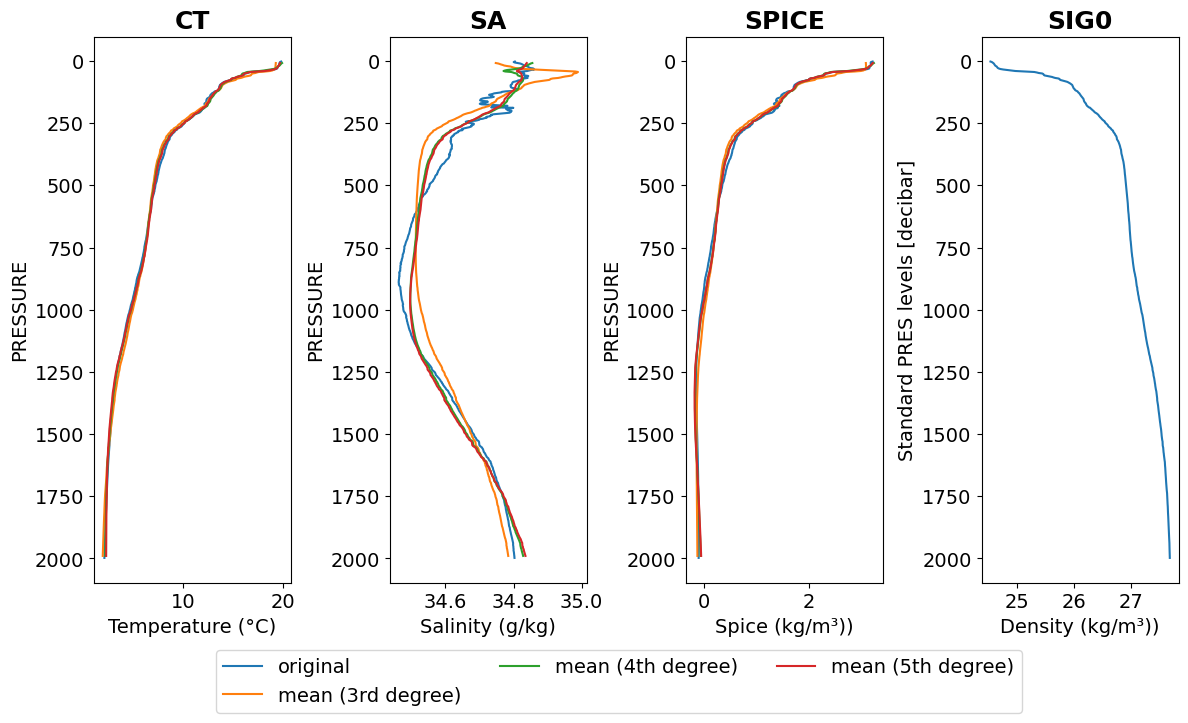

In [41]:
plt.figure(figsize=(14,7))
prof = 1

plt.subplot(141)
section_p.isel(PROFILE=prof).CT.plot(y='PRESSURE', label='original')
section_3.isel(PROFILE=prof).CT_m.plot(y='PRESSURE', label='mean (3rd degree)')
section_4.isel(PROFILE=prof).CT_m.plot(y='PRESSURE', label='mean (4th degree)')
section_5.isel(PROFILE=prof).CT_m.plot(y='PRESSURE', label='mean (5th degree)')
#section_6.isel(PROFILE=prof).CT_m.plot(y='PRESSURE', label='mean (6th degree)')
plt.xlabel('Temperature (°C)')
plt.gca().invert_yaxis()
plt.title('CT')

plt.subplot(142)
section_p.isel(PROFILE=prof).SA.plot(y='PRESSURE')
section_3.isel(PROFILE=prof).SA_m.plot(y='PRESSURE')
section_4.isel(PROFILE=prof).SA_m.plot(y='PRESSURE')
section_5.isel(PROFILE=prof).SA_m.plot(y='PRESSURE')
#section_6.isel(PROFILE=prof).SA_m.plot(y='PRESSURE')
plt.xlabel('Salinity (g/kg)')
plt.gca().invert_yaxis()
plt.title('SA')

plt.subplot(143)
section_p.isel(PROFILE=prof).SPICE.plot(y='PRESSURE')
section_3.isel(PROFILE=prof).SPICE_m.plot(y='PRESSURE')
section_4.isel(PROFILE=prof).SPICE_m.plot(y='PRESSURE')
section_5.isel(PROFILE=prof).SPICE_m.plot(y='PRESSURE')
#section_6.isel(PROFILE=prof).SPICE_m.plot(y='PRESSURE')
plt.xlabel('Spice (kg/m³))')
plt.gca().invert_yaxis()
plt.title('SPICE')

plt.subplot(144)
section_p.isel(PROFILE=prof).SIG0.plot(y='PRESSURE')
plt.xlabel('Density (kg/m³))')
plt.gca().invert_yaxis()
plt.title('SIG0')

plt.subplots_adjust(wspace=0.5, bottom=0.1)
plt.figlegend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3)
print('Polynomial fit performed on entire profiles')

AttributeError: 'Dataset' object has no attribute 'CT_m'

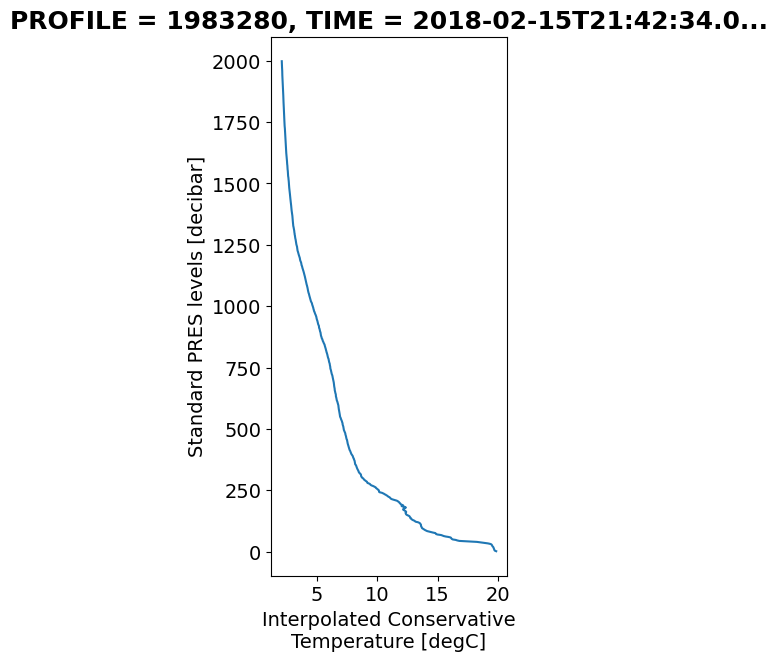

In [40]:
plt.figure(figsize=(14,7))

plt.subplot(141)
prof.CT.plot(y='PRESSURE', label='original')
prof.CT_m.plot(y='PRESSURE', label='mean (4th degree polynomial fit + smoothing)')
plt.xlabel('Temperature (°C)')
plt.title('')
plt.twiny()
prof.CT_e.plot(y='PRESSURE',color='tab:green', label='eddy (original - mean)')
plt.xlabel('')
plt.gca().invert_yaxis()
plt.title('CT')

plt.subplot(142)
prof.SA.plot(y='PRESSURE')
prof.SA_m.plot(y='PRESSURE')
plt.xlabel('Salinity (g/kg)')
plt.title('')
plt.twiny()
prof.SA_e.plot(y='PRESSURE',color='tab:green')
plt.xlabel('')
plt.gca().invert_yaxis()
plt.title('SA')

plt.subplot(143)
prof.SPICE.plot(y='PRESSURE')
prof.SPICE_m.plot(y='PRESSURE')
plt.xlabel('Spice (kg/m³)')
plt.title('')
plt.twiny()
prof.SPICE_e.plot(y='PRESSURE',color='tab:green')
plt.xlabel('')
plt.gca().invert_yaxis()
plt.title('SPICE')

plt.subplot(144)
prof.SIG0.plot(y='PRESSURE')
plt.xlabel('Density SIG0 (kg/m³)')
plt.gca().invert_yaxis()
plt.title('SIG0')

plt.subplots_adjust(wspace=0.5, bottom=0.1)
plt.figlegend(loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3);

Polynomial fit performed on profile slices between 375-1850 dbar


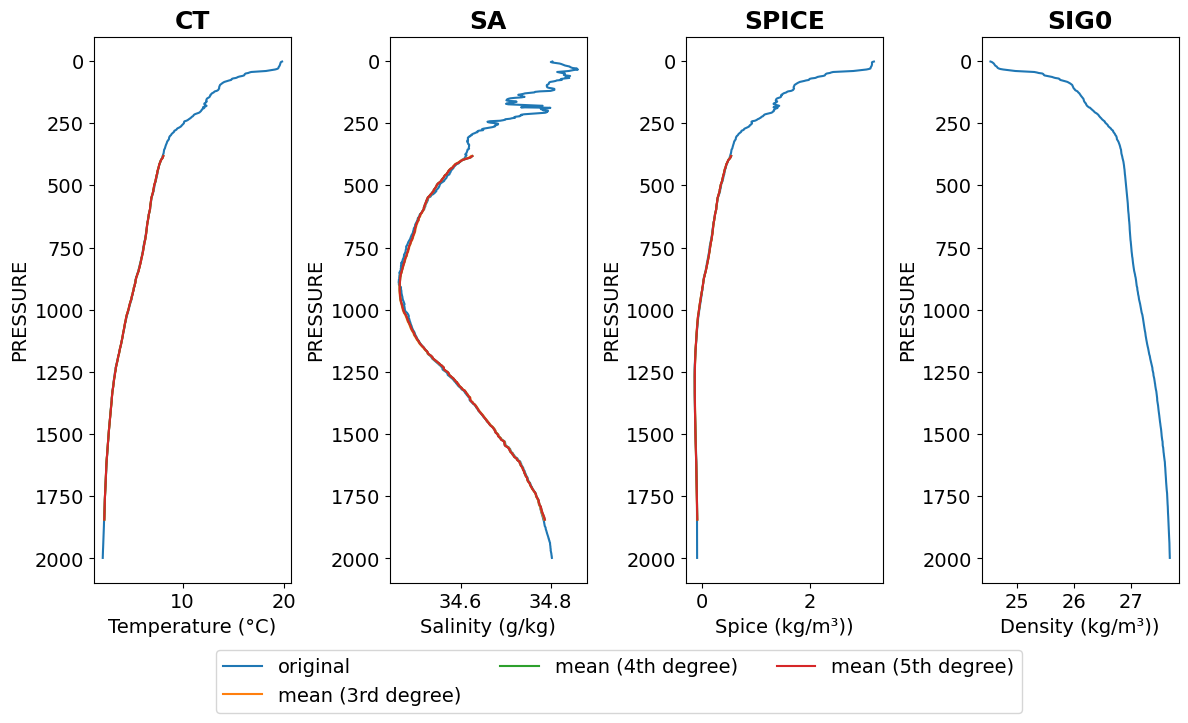

In [ ]:
plt.figure(figsize=(14,7))
prof = 1

plt.subplot(141)
section_p.isel(PROFILE=prof).CT.plot(y='PRESSURE', label='original')
section_3_slice.isel(PROFILE=prof).CT_m.plot(y='PRESSURE', label='mean (3rd degree)')
section_4_slice.isel(PROFILE=prof).CT_m.plot(y='PRESSURE', label='mean (4th degree)')
section_5_slice.isel(PROFILE=prof).CT_m.plot(y='PRESSURE', label='mean (5th degree)')
#section_6_slice.isel(PROFILE=prof).CT_m.plot(y='PRESSURE', label='mean (6th degree)')
plt.xlabel('Temperature (°C)')
plt.gca().invert_yaxis()
plt.title('CT')

plt.subplot(142)
section_p.isel(PROFILE=prof).SA.plot(y='PRESSURE')
section_3_slice.isel(PROFILE=prof).SA_m.plot(y='PRESSURE')
section_4_slice.isel(PROFILE=prof).SA_m.plot(y='PRESSURE')
section_5_slice.isel(PROFILE=prof).SA_m.plot(y='PRESSURE')
#section_6_slice.isel(PROFILE=prof).SA_m.plot(y='PRESSURE')
plt.xlabel('Salinity (g/kg)')
plt.gca().invert_yaxis()
plt.title('SA')

plt.subplot(143)
section_p.isel(PROFILE=prof).SPICE.plot(y='PRESSURE')
section_3_slice.isel(PROFILE=prof).SPICE_m.plot(y='PRESSURE')
section_4_slice.isel(PROFILE=prof).SPICE_m.plot(y='PRESSURE')
section_5_slice.isel(PROFILE=prof).SPICE_m.plot(y='PRESSURE')
#section_6_slice.isel(PROFILE=prof).SPICE_m.plot(y='PRESSURE')
plt.xlabel('Spice (kg/m³))')
plt.gca().invert_yaxis()
plt.title('SPICE')

plt.subplot(144)
section_p.isel(PROFILE=prof).SIG0.plot(y='PRESSURE')
plt.xlabel('Density (kg/m³))')
plt.gca().invert_yaxis()
plt.title('SIG0')

plt.subplots_adjust(wspace=0.5, bottom=0.1)
plt.figlegend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3);
print('Polynomial fit performed on profile slices between 375-1850 dbar')

In [ ]:
K_rho_p = xr.open_dataset('/swot/SUM05/amf2288/global_diff.nc').K.drop_vars(['z_l','z_r','lon_l','lon_r','lat_l','lat_r'])
K_rho_p = K_rho_p.rename({'z_c':'PRESSURE', 'lat_c':'LAT', 'lon_c':'LON'})

In [ ]:
K_rho_sel_p = K_rho_p.sel(LON=section_p.LON.mean(), LAT=section_p.LAT.mean(), method='nearest')
K_rho_sel_p = K_rho_sel_p.interp(PRESSURE=section_p.PRESSURE)

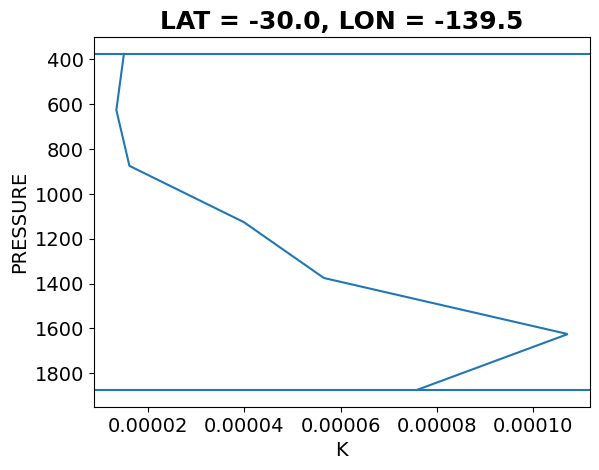

In [ ]:
K_rho_sel_p.plot(y='PRESSURE')
plt.gca().invert_yaxis()
plt.axhline(375)
plt.axhline(1875)

### whole profile

In [ ]:
ct_e_z2 = section_p.CT_e.differentiate(coord='PRESSURE')**2
sa_e_z2 = section_p.SA_e.differentiate(coord='PRESSURE')**2
sp_e_z2 = section_p.SPICE_e.differentiate(coord='PRESSURE')**2

In [ ]:
lfilt=100
ct_e_z2_filt = ff.da_filt_single(ct_e_z2, lfilt, dim1='PROFILE', dim2='PRESSURE', lat='LAT', lon='LON').rename({'lat':'LAT','lon':'LON'})
sa_e_z2_filt = ff.da_filt_single(sa_e_z2, lfilt, dim1='PROFILE', dim2='PRESSURE', lat='LAT', lon='LON').rename({'lat':'LAT','lon':'LON'})
sp_e_z2_filt = ff.da_filt_single(sp_e_z2, lfilt, dim1='PROFILE', dim2='PRESSURE', lat='LAT', lon='LON').rename({'lat':'LAT','lon':'LON'})

In [ ]:
ct2_VPR = K_rho_sel_p*ct_e_z2_filt
sa2_VPR = K_rho_sel_p*sa_e_z2_filt
sp2_VPR = K_rho_sel_p*sp_e_z2_filt

In [ ]:
ct_m_z2 = section_p.CT_m.differentiate(coord='PRESSURE')**2
sa_m_z2 = section_p.SA_m.differentiate(coord='PRESSURE')**2
sp_m_z2 = section_p.SPICE_m.differentiate(coord='PRESSURE')**2

In [ ]:
ct_m_z2_filt = ff.da_filt_single(ct_m_z2, lfilt, dim1='PROFILE', dim2='PRESSURE', lat='LAT', lon='LON').rename({'lat':'LAT','lon':'LON'})
sa_m_z2_filt = ff.da_filt_single(sa_m_z2, lfilt, dim1='PROFILE', dim2='PRESSURE', lat='LAT', lon='LON').rename({'lat':'LAT','lon':'LON'})
sp_m_z2_filt = ff.da_filt_single(sp_m_z2, lfilt, dim1='PROFILE', dim2='PRESSURE', lat='LAT', lon='LON').rename({'lat':'LAT','lon':'LON'})

In [ ]:
ct3_VPR = K_rho_sel_p*ct_m_z2_filt
sa3_VPR = K_rho_sel_p*sa_m_z2_filt
sp3_VPR = K_rho_sel_p*sp_m_z2_filt

In [ ]:
ct_meso_frac = ct2_VPR / (ct2_VPR + ct3_VPR)
sa_meso_frac = sa2_VPR / (sa2_VPR + sa3_VPR)
sp_meso_frac = sp2_VPR / (sp2_VPR + sp3_VPR)

### Slice

In [ ]:
ct_e_z2_slice = section_4_slice.CT_e.differentiate(coord='PRESSURE')**2
sa_e_z2_slice = section_4_slice.SA_e.differentiate(coord='PRESSURE')**2
sp_e_z2_slice = section_4_slice.SPICE_e.differentiate(coord='PRESSURE')**2

In [ ]:
lfilt=100
ct_e_z2_filt_slice = ff.da_filt_single(ct_e_z2_slice, lfilt, dim1='PROFILE', dim2='PRESSURE', lat='LAT', lon='LON').rename({'lat':'LAT','lon':'LON'})
sa_e_z2_filt_slice = ff.da_filt_single(sa_e_z2_slice, lfilt, dim1='PROFILE', dim2='PRESSURE', lat='LAT', lon='LON').rename({'lat':'LAT','lon':'LON'})
sp_e_z2_filt_slice = ff.da_filt_single(sp_e_z2_slice, lfilt, dim1='PROFILE', dim2='PRESSURE', lat='LAT', lon='LON').rename({'lat':'LAT','lon':'LON'})

In [ ]:
ct2_VPR_slice = K_rho_sel_p*ct_e_z2_filt_slice
sa2_VPR_slice = K_rho_sel_p*sa_e_z2_filt_slice
sp2_VPR_slice = K_rho_sel_p*sp_e_z2_filt_slice

In [ ]:
ct_m_z2_slice = section_3_slice.CT_m.differentiate(coord='PRESSURE')**2
sa_m_z2_slice = section_3_slice.SA_m.differentiate(coord='PRESSURE')**2
sp_m_z2_slice = section_3_slice.SPICE_m.differentiate(coord='PRESSURE')**2

In [ ]:
ct_m_z2_filt_slice = ff.da_filt_single(ct_m_z2_slice, lfilt, dim1='PROFILE', dim2='PRESSURE', lat='LAT', lon='LON').rename({'lat':'LAT','lon':'LON'})
sa_m_z2_filt_slice = ff.da_filt_single(sa_m_z2_slice, lfilt, dim1='PROFILE', dim2='PRESSURE', lat='LAT', lon='LON').rename({'lat':'LAT','lon':'LON'})
sp_m_z2_filt_slice = ff.da_filt_single(sp_m_z2_slice, lfilt, dim1='PROFILE', dim2='PRESSURE', lat='LAT', lon='LON').rename({'lat':'LAT','lon':'LON'})

In [ ]:
ct3_VPR_slice = K_rho_sel_p*ct_m_z2_filt_slice
sa3_VPR_slice = K_rho_sel_p*sa_m_z2_filt_slice
sp3_VPR_slice = K_rho_sel_p*sp_m_z2_filt_slice

In [ ]:
ct_meso_frac_slice = ct2_VPR_slice / (ct2_VPR_slice + ct3_VPR_slice)
sa_meso_frac_slice = sa2_VPR_slice / (sa2_VPR_slice + sa3_VPR_slice)
sp_meso_frac_slice = sp2_VPR_slice / (sp2_VPR_slice + sp3_VPR_slice)

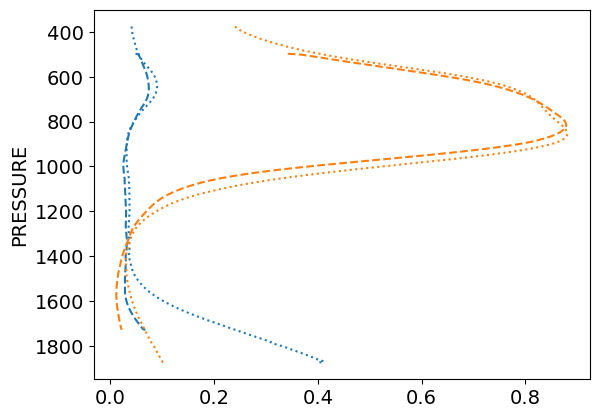

In [ ]:
ct_meso_frac.mean('PROFILE').plot(y='PRESSURE',color='tab:blue',linestyle=':')
ct_meso_frac_slice.mean('PROFILE').plot(y='PRESSURE',color='tab:blue',linestyle='--')
sa_meso_frac.mean('PROFILE').plot(y='PRESSURE',color='tab:orange',linestyle=':')
sa_meso_frac_slice.mean('PROFILE').plot(y='PRESSURE',color='tab:orange',linestyle='--')
plt.gca().invert_yaxis()

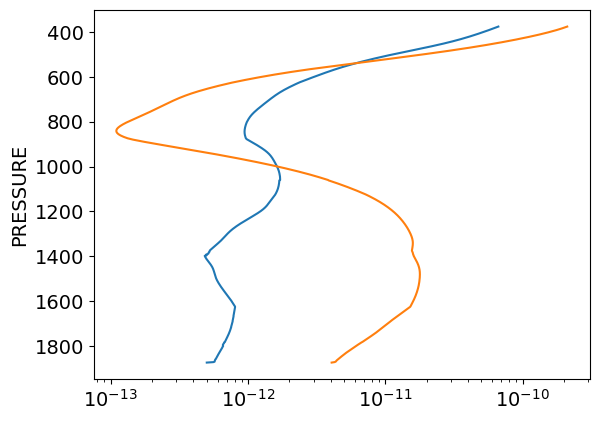

In [ ]:
sa2_VPR.mean('PROFILE').plot(y='PRESSURE')
sa3_VPR.mean('PROFILE').plot(y='PRESSURE')
plt.gca().invert_yaxis()
plt.xscale('log')

In [ ]:
ct2_VPR.to_netcdf('/swot/SUM05/amf2288/box_ct2_VPR.nc')
ct3_VPR.to_netcdf('/swot/SUM05/amf2288/box_ct3_VPR.nc')

sa2_VPR.to_netcdf('/swot/SUM05/amf2288/box_sa2_VPR.nc')
sa3_VPR.to_netcdf('/swot/SUM05/amf2288/box_sa3_VPR.nc')

sp2_VPR.to_netcdf('/swot/SUM05/amf2288/box_sp2_VPR.nc')
sp3_VPR.to_netcdf('/swot/SUM05/amf2288/box_sp3_VPR.nc')